## Detection of correlated input to FS with and without gap junctions.

There are two population units for FS neurons, population unit 1 and population unit 2. In addition there are FS units without a population unit (0). The two population units receive cortical and thalamic input with 2Hz frequency. The correlation of population unit 1 is increased between 1 and 1.1 seconds for the cortical input, and between 2 and 2.1 seconds for the thalamic input.

In [1]:
import os
import numpy as np

os.environ["SNUDDA_DATA"] = "../../../../BasalGangliaData/data/"
assert os.path.isdir(os.getenv("SNUDDA_DATA")), f"You need to have BasalGangliaData installed for this example."

network_path = os.path.join("networks", "FS_correlation_detection")
rc = None

In [2]:
from snudda import SnuddaInit
si = SnuddaInit(network_path=network_path, random_seed=12345)
si.define_striatum(num_dSPN=0, num_iSPN=0, num_FS=50, num_LTS=0, num_ChIN=0)

# The centre of the cube is [0.00475, 0.004, 0.00775]. num_neurons is optional
# First test, we place units on top of each other -- set num_neurons to 8
si.add_population_unit_density(structure_name="Striatum", neuron_types=["FS"], unit_id=1, 
                               unit_centre=np.array([0.00475, 0.004, 0.00775]) -np.array([0, 100e-6, 0]),
                               probability_function="(d < 300e-6)*1", num_neurons=20)
si.add_population_unit_density(structure_name="Striatum", neuron_types=["FS"], unit_id=2, 
                               unit_centre=np.array([0.00475, 0.004, 0.00775]) -np.array([0, 0, 100e-6]),
                               probability_function="(d < 300e-6) * 1", num_neurons=20)
 
si.write_json()

Using cube for striatum
Neurons for striatum read from /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum
Adding neurons: FS from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/fs
Writing networks/FS_correlation_detection/network-config.json


In [3]:
# Smaller network -- TESTING
if False:
    from snudda import SnuddaInit
    si = SnuddaInit(network_path=network_path, random_seed=12345)
    si.define_striatum(num_dSPN=0, num_iSPN=0, num_FS=10, num_LTS=0, num_ChIN=0)

    # The centre of the cube is [0.00475, 0.004, 0.00775]. num_neurons is optional
    # First test, we place units on top of each other -- set num_neurons to 8
    si.add_population_unit_density(structure_name="Striatum", neuron_types=["FS"], unit_id=1, 
                                   unit_centre=np.array([0.00475, 0.004, 0.00775]) -np.array([0, 100e-6, 0]),
                                   probability_function="(d < 300e-6)*1", num_neurons=4)
    si.add_population_unit_density(structure_name="Striatum", neuron_types=["FS"], unit_id=2, 
                                   unit_centre=np.array([0.00475, 0.004, 0.00775]) -np.array([0, 0, 100e-6]),
                                   probability_function="(d < 300e-6) * 1", num_neurons=4)

    si.write_json()

In [4]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path)
sp.place()

Reading SNUDDA_DATA=None from networks/FS_correlation_detection/network-config.json
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from environment variable $SNUDDA_DATA


### Plotting the network
Plotting the network to verify that the population units are placed the way we expect.

Reading SNUDDA_DATA=None from networks/FS_correlation_detection/network-config.json
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from environment variable $SNUDDA_DATA
Population unit 0 has 10 neurons
Population unit 1 has 20 neurons
Population unit 2 has 20 neurons


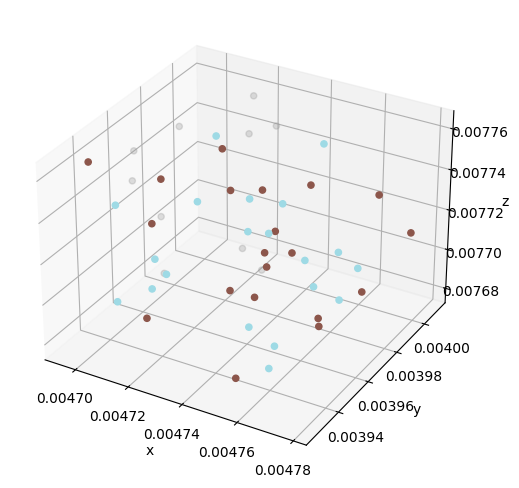

In [5]:
from snudda.plotting import PlotNetwork
pos_file = os.path.join(network_path, "network-neuron-positions.hdf5")

pn = PlotNetwork(pos_file)
pn.plot_populations()

# The commented code below also plots the network, but with the option to plot more detail of the neurons:
# pn = PlotNetwork(network_path)
# pn.plot(plot_axon=False, plot_dendrite=False, plot_synapses=False, colour_population_unit=True)

pn.close()  # Close the hdf5 file so others can use it (or better shut down kernel after)

### Check if ipyparallel running
For larger networks it is useful to run network creation in parallel.

In [6]:
import os
from ipyparallel import Client

os.environ["IPYTHONDIR"] = ".ipython"
os.environ["IPYTHON_PROFILE"] = "default"

u_file = os.path.join(".ipython", "profile_default", "security", "ipcontroller-client.json")
if os.path.exists(u_file):
    rc = Client(url_file=u_file, timeout=120, debug=False)
else:
    print("Warning, running in serial.")
    rc = None

Warning, running in serial.


In [7]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, rc=rc, verbose=False)
sd.detect()

Reading SNUDDA_DATA=None from networks/FS_correlation_detection/network-config.json
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from environment variable $SNUDDA_DATA
No d_view specified, running distribute neurons in serial
Processing hyper voxel : 115/336 (50 neurons)
Processing hyper voxel : 163/336 (50 neurons)
Processing hyper voxel : 171/336 (48 neurons)
Processing hyper voxel : 116/336 (46 neurons)
Processing hyper voxel : 123/336 (45 neurons)
Processing hyper voxel : 164/336 (44 neurons)
Processing hyper voxel : 124/336 (36 neurons)
Processing hyper voxel : 155/336 (35 neurons)
Processing hyper voxel : 162/336 (34 neurons)
Processing hyper voxel : 107/336 (32 neurons)
Processing hyper voxel : 172/336 (30 neurons)
Processing hyper voxel : 114/336 (26 neurons)
Processing hyper voxel : 156/336 (25 neurons)
Processing hyper voxel : 108/336 (24 neurons)
Processing hyper voxel : 122/336 (19 neurons)
Processing hyper voxel : 170/336 (18 neurons)
Processing hyper voxel : 67/

In [8]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path, rc=rc, verbose=False)
sp.prune()

Read 42660 out of total 42660 synapses
Read 5650 out of total 5650 gapJunctions


### Generate input

Next we generate the input according to specifications in [FS-input-correlation-detection-1.json](FS-input-correlation-detection-1.json)

In [9]:
from snudda.input import SnuddaInput
si = SnuddaInput(network_path=network_path, 
                 input_config_file=os.path.join("FS-input-correlation-detection-1.json"),
                 time=1.5,
                 rc=rc, verbose=False)
si.generate()

Reading SNUDDA_DATA=None from networks/FS_correlation_detection/network-config.json
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from environment variable $SNUDDA_DATA
Loading 50 neurons with 4950 synapses and 1778 gap junctions
!!! Warning, combining definition of cortical_background input for neuron FS_2 0 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 0 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_0 1 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_0 1 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 2 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 2 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 3 (m

### Plot the input to verify it looks reasonable

In [10]:
from snudda.plotting import PlotInput
input_file = os.path.join(network_path, "input-spikes.hdf5")
spi = PlotInput(input_file)

Loading 50 neurons with 4950 synapses and 1778 gap junctions


Input to FS population unit 1. Here we have a correlation increase in cortical input between 0.4 and 0.55 seconds, and in thalamic input between 1 and 1.15 seconds.

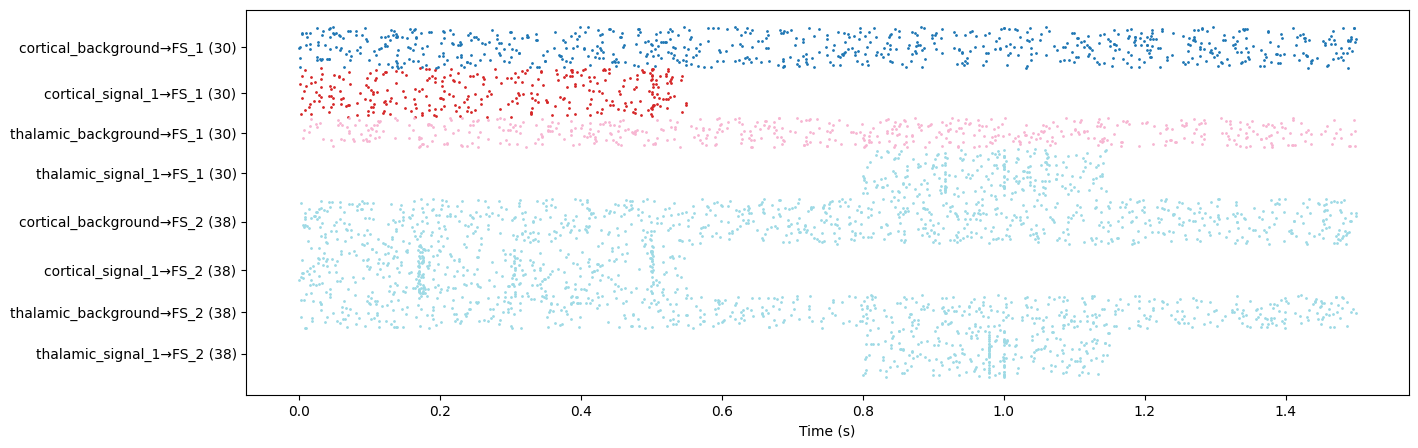

In [11]:
spi.plot_input_population_unit(population_unit_id=1, num_neurons=2, neuron_type="FS", fig_size=(15,5))

FS population unit 2 receives elevated input but no change in correlation.

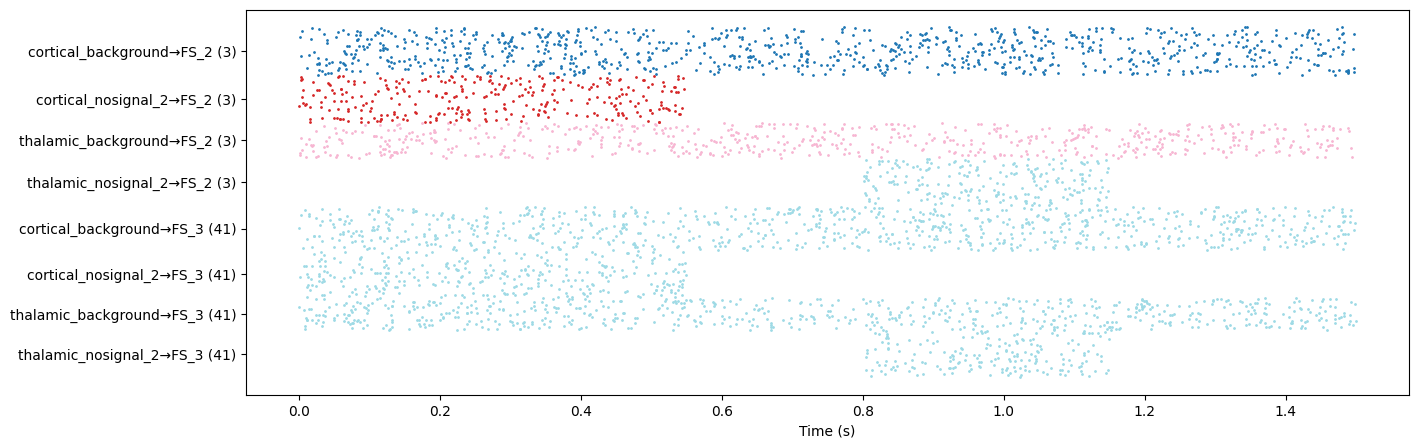

In [12]:
spi.plot_input_population_unit(population_unit_id=2, num_neurons=2, neuron_type="FS", fig_size=(15,5))

FS neurons without population unit receive the same low background input constantly.

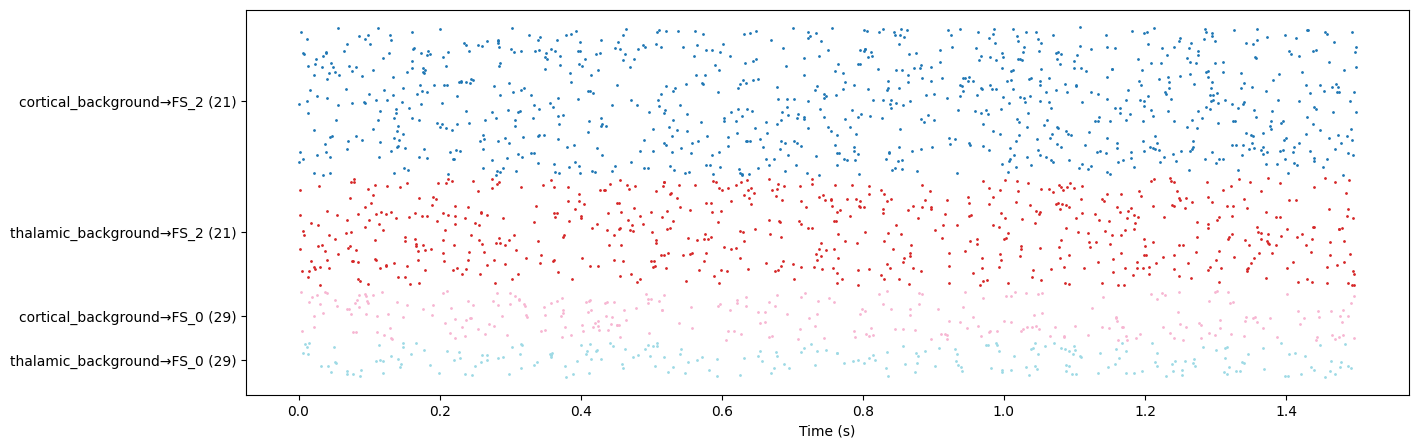

In [13]:
spi.plot_input_population_unit(population_unit_id=0, num_neurons=2, neuron_type="FS", fig_size=(15,5))

### Compile neuron modules

In [14]:
!nrnivmodl ../../../../BasalGangliaData/data/neurons/mechanisms

/home/hjorth/HBP/Snudda/examples/notebooks/FS-network
Mod files: "../../../../BasalGangliaData/data/neurons/mechanisms/../../../../BasalGangliaData/data/neurons/mechanisms/bk_ch.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/../../../../BasalGangliaData/data/neurons/mechanisms/bk_fs.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/../../../../BasalGangliaData/data/neurons/mechanisms/bk_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/../../../../BasalGangliaData/data/neurons/mechanisms/ca_ch.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/../../../../BasalGangliaData/data/neurons/mechanisms/cadyn_fs.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/../../../../BasalGangliaData/data/neurons/mechanisms/cadyn_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/../../../../BasalGangliaData/data/neurons/mechanisms/cal12_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/../../../../BasalGangliaData/data/neurons/mech

### Run the simulation

In [15]:
!mpiexec -n 3 snudda simulate networks/FS_correlation_detection --time 2

numprocs=3
Creating missing directory networks/FS_correlation_detection/simulation
Created directory networks/FS_correlation_detection/simulation
Using input file networks/FS_correlation_detection/input-spikes.hdf5
Reading SNUDDA_DATA=None from networks/FS_correlation_detection/network-config.json
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from environment variable $SNUDDA_DATA
Worker waiting for master node to compile NEURON modules.
Using input file networks/FS_correlation_detection/input-spikes.hdf5
Reading SNUDDA_DATA=None from networks/FS_correlation_detection/network-config.json
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from environment variable $SNUDDA_DATA
Worker waiting for master node to compile NEURON modules.
Using input file networks/FS_correlation_detection/input-spikes.hdf5
Reading SNUDDA_DATA=None from networks/FS_correlation_detection/network-config.json
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from environment variable $SNUDDA_DA

In [16]:
!mpiexec -n 3 snudda simulate networks/FS_correlation_detection --time 2 --disableGJ --outputFile networks/FS_correlation_detection/simulation/output-no-GJ.hdf5

numprocs=3
Using input file networks/FS_correlation_detection/input-spikes.hdf5
Using input file networks/FS_correlation_detection/input-spikes.hdf5
Reading SNUDDA_DATA=None from networks/FS_correlation_detection/network-config.json
Reading SNUDDA_DATA=None from networks/FS_correlation_detection/network-config.json
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from environment variable $SNUDDA_DATA
Worker waiting for master node to compile NEURON modules.
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from environment variable $SNUDDA_DATA
Worker waiting for master node to compile NEURON modules.
Using input file networks/FS_correlation_detection/input-spikes.hdf5
Reading SNUDDA_DATA=None from networks/FS_correlation_detection/network-config.json
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from environment variable $SNUDDA_DATA
Running on master node:  nrnivmodl /home/hjorth/HBP/BasalGangliaData/data/neurons/mechanisms
/home/hjorth/HBP/Snudda/examples/notebo

Loading networks/FS_correlation_detection/simulation/output.hdf5
WARNING. Depolarisation block in neuron - neuron_id: (name, parameter_key, morphology_key):
8: (FS_3, pd31ea15f, mb1b67bcc)
39: (FS_3, pc047576c, mb1b67bcc)


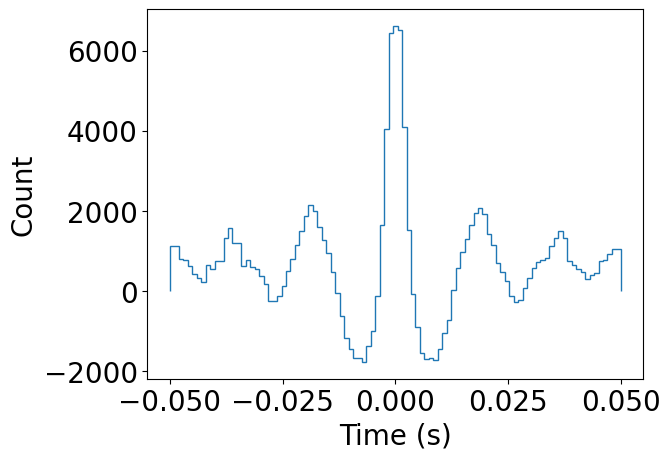

Creating directory networks/FS_correlation_detection/figures


<Figure size 640x480 with 0 Axes>

In [17]:
from snudda.plotting.plot_cross_correlogram import PlotCrossCorrelogram
pcc1 = PlotCrossCorrelogram(os.path.join(network_path, "simulation", "output.hdf5"))
pcc1.plot_all_pair_cross_correlogram(neuron_id=None, fig_file_name=os.path.join(network_path, "figures", "FS-cross-corr.png"))

Loading networks/FS_correlation_detection/simulation/output-no-GJ.hdf5
WARNING. Depolarisation block in neuron - neuron_id: (name, parameter_key, morphology_key):
13: (FS_1, pf9439e45, mf0a83676)
15: (FS_0, p59a48310, m9175e580)
16: (FS_0, p4feff98b, m4cd420e2)
43: (FS_1, pf86c86e4, mf0a83676)
44: (FS_0, p59a48310, m15ae4048)


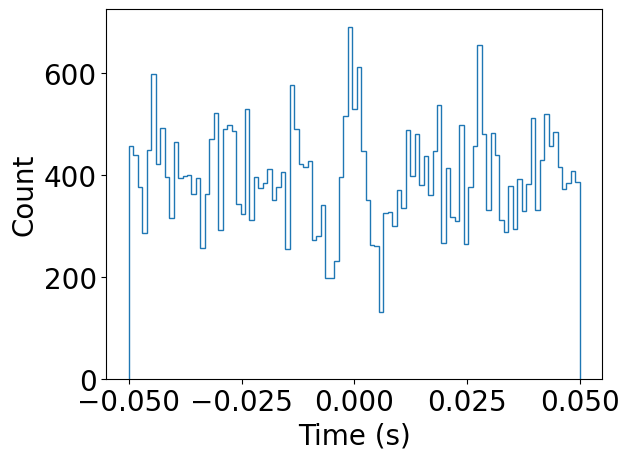

<Figure size 640x480 with 0 Axes>

In [18]:
pcc2 = PlotCrossCorrelogram(os.path.join(network_path, "simulation", "output-no-GJ.hdf5"))
pcc2.plot_all_pair_cross_correlogram(neuron_id=None, fig_file_name=os.path.join(network_path, "figures", "FS-cross-corr-no-gj.png"))

### Plotting

We want to plot the binned frequency for the different populations as a function of time, to see if there is a difference in output frequency during 0.4-0.55 seconds and 1-1.15 seconds. 

Loading 50 neurons with 4950 synapses and 1778 gap junctions
Loading networks/FS_correlation_detection/simulation/output.hdf5
WARNING. Depolarisation block in neuron - neuron_id: (name, parameter_key, morphology_key):
8: (FS_3, pd31ea15f, mb1b67bcc)
39: (FS_3, pc047576c, mb1b67bcc)
Saving figure to networks/FS_correlation_detection/figures/spike_raster.pdf


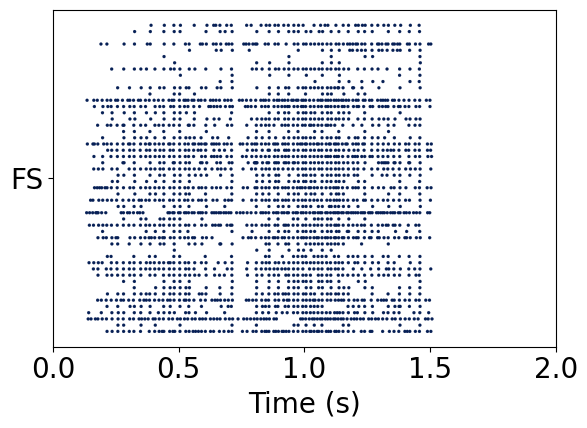

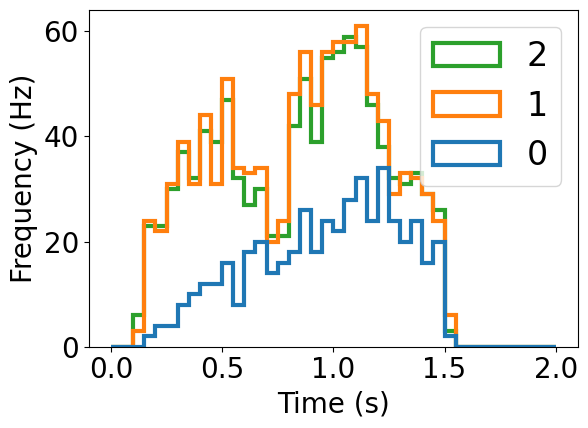

<AxesSubplot:xlabel='Time (s)', ylabel='Frequency (Hz)'>

In [21]:
from snudda.plotting import SnuddaPlotSpikeRaster2
sim_file = os.path.join(network_path, "simulation", "output.hdf5")
fig_file = os.path.join(network_path, "figures")
spr = SnuddaPlotSpikeRaster2(network_path=network_path, simulation_file=sim_file, figure_path=fig_file)
spr.plot_spike_raster()
spr.plot_spike_histogram()

Loading 50 neurons with 4950 synapses and 1778 gap junctions
Loading networks/FS_correlation_detection/simulation/output-no-GJ.hdf5
WARNING. Depolarisation block in neuron - neuron_id: (name, parameter_key, morphology_key):
13: (FS_1, pf9439e45, mf0a83676)
15: (FS_0, p59a48310, m9175e580)
16: (FS_0, p4feff98b, m4cd420e2)
43: (FS_1, pf86c86e4, mf0a83676)
44: (FS_0, p59a48310, m15ae4048)
Saving figure to networks/FS_correlation_detection/figures/spike_raster.pdf


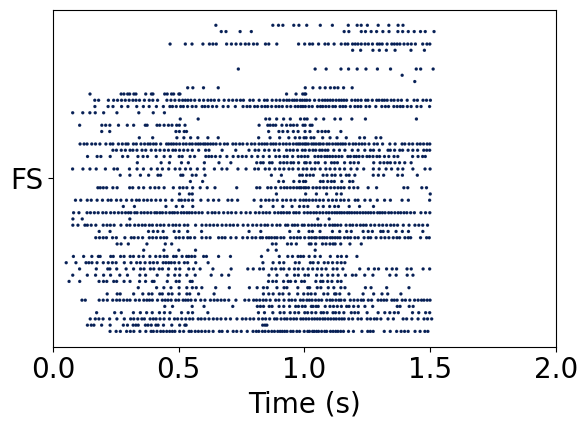

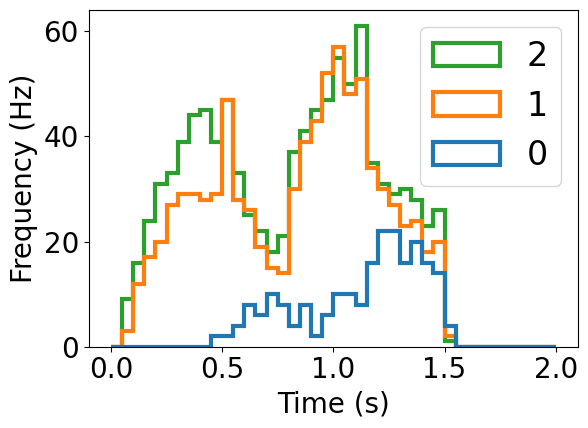

<AxesSubplot:xlabel='Time (s)', ylabel='Frequency (Hz)'>

In [22]:
from snudda.plotting import SnuddaPlotSpikeRaster2
sim_file_no_gj = os.path.join(network_path, "simulation", "output-no-GJ.hdf5")
fig_file_no_gj = os.path.join(network_path, "figures")
spr2 = SnuddaPlotSpikeRaster2(network_path=network_path, simulation_file=sim_file_no_gj, figure_path=fig_file_no_gj)
spr2.plot_spike_raster()
spr2.plot_spike_histogram()

'networks/FS_correlation_detection/figures/spike-raster-gj.pdf'